In [1]:
import sys
sys.path.append('/home/spiridon/bin/Bio_workbench')
import finditfasta
import os
import pandas as pd
import numpy as np
import rpy2
%load_ext rpy2.ipython
catalog=finditfasta.Catalog('/home/spiridon/Documents/projects/Viral_MT/data/catalog')

Building taxonomy catalog.... [DONE]


# Evaluating the Methyltransferases in all Viruses

The purpose is to find all methyltransferases that exisit in both eukaryotic and prokaryotic double stranded DNA viruses.

#### project folders
- src
- figures
- data

## Search Strategy 
We will obtain all viral sequencing data from genbank and refseq, where if there are redundancies between both data sources, we will default to refseq. Due to the differences in gene calling for defining CDS, we will translate all frames and then run the RM search pipline to find MTases and any possible cognate endonuclease.

In [2]:
gb_dir="/media/spiridon/4TbWesterDigital/Viruses/"
fasta_dir="/media/spiridon/4TbWesterDigital/Viral_fastas_allframes_translated/"

assemblies=catalog.download_subtree(10239,gb_dir)
print("Translating all frames for each fasta file..")
files=os.listdir(gb_dir)
for i,file in enumerate(files):
    assembly = file.split('.')[0]
    print("processing assembly: "+assembly+'     '+''.join([str(i+1),'/',str(len(files))]),end='\r')
    gencode=catalog.get_gencode(assembly)
    org=finditfasta.ORG(gb_dir+file)
    fasta=org.translate_allframes(gencode)
    fasta.write_file(fasta_dir+assembly+'.fasta')

Preparing to download 0 files belonging to taxid Viruses
Translating all frames for each fasta file..


In [12]:
#this part is a little hacky... I have not implemented Fasta formats into the Organsim module 
f=open('data/manually_added_genomes/Partial_NCLDV_Genomes.txt','r')
org=finditfasta.Organism.ORG('data/manually_added_genomes/Partial_NCLDV_Genomes.txt')
header=f.readline().strip()[1:]
seq=f.readline().strip()
org.locus_DNA[header]=seq.lower()
gencode=1

fasta=org.translate_allframes(gencode)
fasta.write_file(fasta_dir+'Partial_NCLDV_Genomes.fasta')
print(header.split()[0])
print(len(seq))
print(len(fasta))

KY322437.1_Tetraselmis_virus_1_complete_genome
668031
57154


In [5]:
%%bash
python3 src/RMsearch_virus.py /media/spiridon/4TbWesterDigital/Viral_fastas_allframes_translated/ data/search_results/
python3 src/RMsearchVirus_postprocessing.py /home/spiridon/Documents/projects/Viral_MT/data/search_results/ data/orgidvirus_RMENZcounts.postprocessing.csv



Building a new DB, current time: 07/10/2018 13:59:26
New DB name:   /tmp/Partial_NCLDV_Genomes_pv9lbrq9_BioScan_temp/BLASTdb_Partial_NCLDV_Genomes
New DB title:  /tmp/Partial_NCLDV_Genomes_pv9lbrq9_BioScan_temp/Partial_NCLDV_Genomes.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 57154 sequences in 1.2628 seconds.
Analyzing: Partial_NCLDV_Genomes
Auto formating hmmsearch results file into tab delimited csv file
Partial_NCLDV_Genomes Complete
########################


runtime: 0:00:17.148723


In [6]:
fasta_dir_refseqonly = 'data/refseqCDS_fastas/'
files=os.listdir(gb_dir)
gb_dir="/media/spiridon/4TbWesterDigital/Viruses/"
for i,file in enumerate(files):
    assembly = file.split('.')[0]
    if assembly[0:3] == 'GCF':
        print("processing assembly: "+assembly,end='\r')
        org=finditfasta.ORG(gb_dir+file)
        fasta = org.get_CDSfasta()
        fasta.write_file(fasta_dir_refseqonly+assembly+'.fasta')

In [7]:
%%bash
python3 src/RMsearch_virus.py data/refseqCDS_fastas/ data/search_results_refseqCDS/
python3 src/RMsearchVirus_postprocessing.py data/search_results_refseqCDS/ data/orgidvirus_RMENZcounts_refseqCDS.postprocessing.csv

runtime: 0:00:00.600511


In [ ]:
%%bash
python3 src/get_genomic_info.py

#### Datasets

Refseq and Genbank (redundancies removed) where all open reading frames are translated and searched with the RM pipeline

Refseq only, where annotated CDS are found with RM pipeline

We have resources from [Refseq NCBI mapping virus and host (taxid10239.nbr)](https://www.ncbi.nlm.nih.gov/genomes/GenomesGroup.cgi?taxid=10239&cmd=download2). Additionally, virushost curates data from Refseq and provides a nicely [formated file (virushostdb.tsv)](ftp://ftp.genome.jp/pub/db/virushostdb/virushostdb.tsv). We will first try and use virushostdb.tsv because it provides taxids that should work with our catalog. If there are a signficant number of double stranded DNA viruses that are missing in this curated dataset, we will resort to taxid10239.nbr in order extract host information (however this will be slightly more labor intensive because the provide only accessions, not taxids)

In [3]:
#We will try and extend the virushost database
#First, we will consolidate host data into one corrosponding taxid
#Second, we will use the viral host data from higher tanomic ranks and distribute
#them to lower taxonomic ranks (the subtree will inherit host data)
#and differentiate between host data that was inherited vs
#not inherited

virushost = pd.read_csv('data/virushostdb.tsv',sep='\t',na_filter=False)
virushost = virushost.set_index('virus tax id')
m=[]
seen=set()
for viraltaxid in set(virushost.index.values):
    virus_dat=virushost.loc[viraltaxid,['host tax id','evidence']]
    #processing for Dataframe
    if isinstance(virus_dat,pd.core.frame.DataFrame):
        hosttaxid=[]
        #removing empty cells
        for el in list(virus_dat['host tax id']):
            if el:
                hosttaxid.append(int(el))
        if hosttaxid:
            lca = catalog.find_LCA(hosttaxid)
            try:
                host_domain = catalog.get_lineage(lca).split(';')[2]
            except IndexError:
                host_domain=catalog.get_lineage(lca)
            hosttaxid = ';'.join([str(x) for x in hosttaxid])
            evidence = ';'.join(list(virus_dat['evidence']))
        else:
            hosttaxid = ''
            host_domain = ''
            evidence = ''
    #processing for series
    else:
        if virus_dat['host tax id']:
            hosttaxid = int(virus_dat['host tax id'])
            try:
                host_domain = catalog.get_lineage(hosttaxid).split(';')[2]
            except IndexError:
                host_domain=catalog.get_lineage(hosttaxid)
            evidence = virus_dat['evidence']
        else:
            hosttaxid = ''
            host_domain = ''
            evidence = ''
    seen.add(viraltaxid)
    m.append([viraltaxid,hosttaxid,host_domain,evidence,'False'])

inherited=[]
for row in m:
    taxid,host_tax,host_domain,evidence,is_inherited=row
    subtree_taxids=catalog.get_subtree_taxids(taxid)
    for subtax in subtree_taxids:
        if subtax not in seen:
            inherited.append([subtax,host_tax,host_domain,evidence,'True'])
            seen.add(subtax)
m.extend(inherited)
virushost= pd.DataFrame(m)
virushost.columns = ['viral_taxid', 'host_taxid', 'host_domain', 'evidence', 'is_inherited']
#dropping taxids where host is ambiguous
#virushost = virushost.loc[virushost['host_domain'].isin(['Bacteria', 'Eukaryota', 'Archaea'])]


In [4]:
#we will now infer host_domain by finding the LCA of every subtree in 
#the viral tree of life. When a the host_domain of a subtree is all the same,
#we will descend through the subtree and add those taxids to our virus host
#for this to work, we will need to remove rows where host_domain !=
#Bacteria, Eukaryota, or Archaea
viral_taxids = set(catalog.get_subtree_taxids(10239))
has_evidence = set(virushost['viral_taxid'])
nohost = list(viral_taxids.difference(has_evidence))

virushost_indexed=virushost.set_index('viral_taxid')
seen = set(virushost['viral_taxid'])
m=[]
for taxid in nohost:
    #have we seen it before?
    if taxid not in seen:
        #does it have a subtree?
        subtree = set(catalog.get_subtree_taxids(taxid))
        if subtree:
            #gather all taxids with evidence
            subtree_evidence = list(has_evidence.intersection(subtree))
            host_domain=set(virushost_indexed.loc[subtree_evidence,'host_domain'])
            #print(str(taxid)+'    '+str(host_domain))
            if len(host_domain) == 1:
                host_domain = host_domain.pop()
                m.append([taxid,'',host_domain,'inferred_taxonomically','True'])
                seen.add(taxid)
                LCA = catalog.find_LCA(subtree_evidence)
                #we will add all descendants
                for LCA_tax in catalog.get_subtree_taxids(LCA):
                    if LCA_tax not in seen:
                        m.append([LCA_tax,'',host_domain,'inferred_taxonomically','True'])
                        seen.add(LCA_tax)
#lets concatinate the new data to virushost
df_temp = pd.DataFrame(m)
df_temp.columns = ['viral_taxid', 'host_taxid', 'host_domain', 'evidence', 'is_inherited']
virushost = virushost.append(df_temp)
virushost=virushost.set_index('viral_taxid')

In [8]:
#collate data
#table with the following columns:
#assembly, CDS type (allframes or annotated),[genome info], [host info], [RMdat]
genomedat = pd.read_csv('data/Genomesizes_Viruses.csv',sep='\t',na_filter=False)
genomedat = genomedat.set_index('orgid')

#adding some sequence manually
genomedat.loc['Partial_NCLDV_Genomes']=[668031,1,'',57154,'KY322437','']
catalog.add_manual_assembly('Partial_NCLDV_Genomes',12429) #unclassified viruses

RMdat = pd.read_csv('data/orgidvirus_RMENZcounts.postprocessing.csv',sep='\t',na_filter=False)
RMdat = RMdat.set_index('#orgid')

RMdat_refseqCDS = pd.read_csv('data/orgidvirus_RMENZcounts_refseqCDS.postprocessing.csv',sep='\t')
RMdat_refseqCDS = RMdat_refseqCDS.set_index('#orgid')

genome_columns=['bp','numcontigs','accession']
host_columns =['host_taxid','host_domain','evidence','is_inherited']
#we will gather data based on RMdat
def gather(rmdf,cdstype):
    collate=[]
    for row in rmdf.itertuples():
        assembly = row[0]
        if assembly == 'Partial_NCLDV_Genomes':
            taxid = 12429
        else:
            taxid = catalog.get_taxid(assembly)
        #getting hostdat
        try:
            hostdat=list(virushost.loc[taxid,host_columns])
        except KeyError:
            hostdat = ['']*len(host_columns)
        #gathering genome dat
        if cdstype == 'allframes':
            genome_stats = list(genomedat.loc[assembly,genome_columns+['numCDS_allframes']])
        else:
            genome_stats = list(genomedat.loc[assembly,genome_columns+['numCDS']])
        #gather RMdat
        RM_stats = list(row[1:])
        collate.append([assembly,cdstype]+hostdat+genome_stats+RM_stats)
    return(collate)

viraldat = gather(RMdat,'allframes')
viraldat.extend(gather(RMdat_refseqCDS,'refseqCDS'))
viraldat = pd.DataFrame(viraldat)
viraldat.columns = ['assembly','CDStype']+host_columns + genome_columns+ ['numCDS'] + list(RMdat.columns)
viraldat['virus_RM']=viraldat['T1_RM']+viraldat['T2_RM']+viraldat['T3_RM']+viraldat['T4']+viraldat['T2G']+viraldat['pT2G']
viraldat['virus_MTtotal']=viraldat['T1_M']+viraldat['T2_M']+viraldat['T3_M']+viraldat['T2G']+viraldat['pT2G']
viraldat['virus_lineage'] = [catalog.get_lineage(assembly).split(';')[2] for assembly in viraldat['assembly']]

#We will now filter viral data to remove rows that do not contain a host_taxid or unknown host_domain
#viraldat['host_domain'].replace('', np.nan, inplace=True)
#viraldat.dropna(subset=['host_domain'], inplace=True)
viraldat.to_csv('data/viraldat.csv',sep='\t')
print('Process Completed')


Process Completed


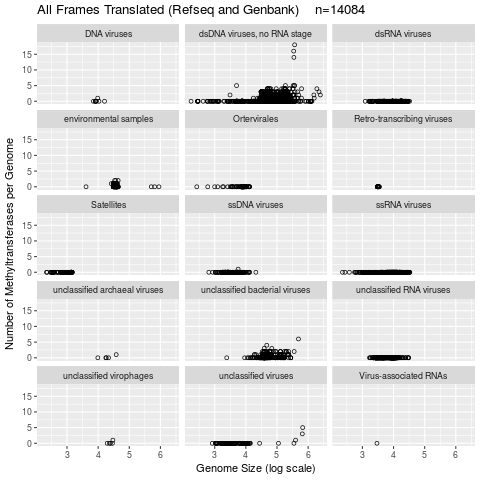

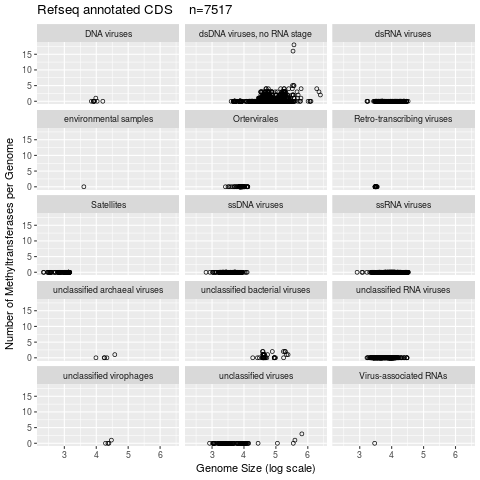

In [18]:
%%R 
dat<-read.csv('/home/spiridon/Documents/projects/Viral_MT/data/viraldat.csv',sep='\t')
library(ggplot2)

allframes <- dat[which(dat$CDStype=='allframes'),]
refseq <- dat[which(dat$CDStype=='refseqCDS'),]

plt1<-ggplot(allframes, aes(x=log10(bp) ,y=virus_MTtotal)) + geom_point(shape=1)+
  facet_wrap(~ virus_lineage, ncol=3)+ 
  ggtitle(paste(c('All Frames Translated (Refseq and Genbank)    n=',nrow(allframes)), collapse = ""))+
  ylab('Number of Methyltransferases per Genome') + xlab('Genome Size (log scale)')

plt2<-ggplot(refseq, aes(x=log10(bp) ,y=virus_MTtotal)) + geom_point(shape=1)+
  facet_wrap(~ virus_lineage, ncol=3)+ 
  ggtitle(paste(c('Refseq annotated CDS    n=',nrow(refseq)), collapse = ""))+
  ylab('Number of Methyltransferases per Genome') + xlab('Genome Size (log scale)')



plotlist = list()
plotlist[[1]]=plt1
plotlist[[2]]=plt2
pdf("figures/MTase_allvirallineages.pdf")
invisible(lapply(plotlist, print))
dev.off()

print(plt1)
print(plt2)


In [19]:
#we will now subset viraldata into dsDNA only
dsDNA=viraldat.loc[(viraldat['virus_lineage'] == 'dsDNA viruses, no RNA stage')]
dsDNA.to_csv('data/dsDNAviruses.csv',sep='\t')
dsDNA

,assembly,CDStype,host_taxid,host_domain,evidence,is_inherited,bp,numcontigs,accession,numCDS,...,orphanMTases,pEndo,pRM,T4,T2G,pT4,pT2G,virus_RM,virus_MTtotal,virus_lineage
0,GCA_000320725,allframes,,,,,1193433,10,AFYC01000008;AFYC01000001;AFYC01000007;AFYC010...,155542,...,0,0,0,0,0,0,0,0,0,"dsDNA viruses, no RNA stage"
2,GCA_000838025,allframes,29058,Eukaryota,,False,131405,1,AF271059,11999,...,0,0,0,0,0,0,0,0,0,"dsDNA viruses, no RNA stage"
5,GCF_000846545,allframes,1763,Bacteria,UniProt,False,52297,1,NC_001335,2198,...,0,0,0,0,0,0,0,0,0,"dsDNA viruses, no RNA stage"
6,GCA_000845685,allframes,9606,Eukaryota,"RefSeq, UniProt",False,159378,1,X83413,14543,...,0,0,0,0,0,0,0,0,0,"dsDNA viruses, no RNA stage"
9,GCF_000846585,allframes,9544,Eukaryota,Literature,False,171096,1,NC_006146,8579,...,0,0,0,0,0,0,0,0,0,"dsDNA viruses, no RNA stage"
11,GCF_000846625,allframes,1582,Bacteria,RefSeq,False,39166,1,NC_005893,3614,...,0,0,0,0,0,0,0,0,0,"dsDNA viruses, no RNA stage"
13,GCF_000846645,allframes,1280,Bacteria,"RefSeq, UniProt",False,148317,1,NC_005880,21757,...,0,0,0,0,0,0,0,0,0,"dsDNA viruses, no RNA stage"
16,GCA_000869385,allframes,51655,Eukaryota,,False,134417,1,DQ457003,12199,...,0,0,0,0,0,0,0,0,0,"dsDNA viruses, no RNA stage"
17,GCF_000846685,allframes,9606,Eukaryota,"RefSeq, UniProt",False,34214,1,NC_001454,2479,...,0,0,0,0,0,0,0,0,0,"dsDNA viruses, no RNA stage"
18,GCA_000872585,allframes,662,Bacteria,,False,33507,1,AB374228,2681,...,0,0,0,0,0,0,0,0,0,"dsDNA viruses, no RNA stage"


In [20]:
#we will now need to run a control to see how well Refseq annotation and all frames translated differs
refseq_allframe_annotated={}
for row in dsDNA.itertuples():
    assembly,CDStype,MT = row[1],row[2],row[-2]
    if assembly[0:3] == 'GCF':
        if assembly not in refseq_allframe_annotated:
            refseq_allframe_annotated[assembly] = [assembly,None,None]
        if CDStype == 'allframes':
            refseq_allframe_annotated[assembly][1] = MT
        else:
            refseq_allframe_annotated[assembly][2] = MT
#make sure we found all pairs
m=[]
for assembly in refseq_allframe_annotated:
    #remove if either are None
    if None not in refseq_allframe_annotated[assembly]:
        #remove ones where both are zero
        m.append(refseq_allframe_annotated[assembly])
coord_count={}
for el in m:
    coord = (el[1],el[2])
    if coord in coord_count:
        coord_count[coord]+=1
    else:
        coord_count[coord]=1
forheatmap = pd.DataFrame( [[coord[0],coord[1],coord_count[coord]] for coord in coord_count] )
forheatmap.columns=['allframes','annotatedCDS','frequency']
CDSpairs = pd.DataFrame(m)
CDSpairs.columns = ['assembly','allframes_MTcount','annotatedCDS_MTcount']
CDSpairs.to_csv('data/CDSvsAllframes.csv',sep='\t')
forheatmap

,allframes,annotatedCDS,frequency
0,0,1,1
1,1,2,1
2,3,2,1
3,0,0,2119
4,3,3,46
5,4,4,10
6,2,1,6
7,2,0,4
8,18,18,1
9,16,16,1


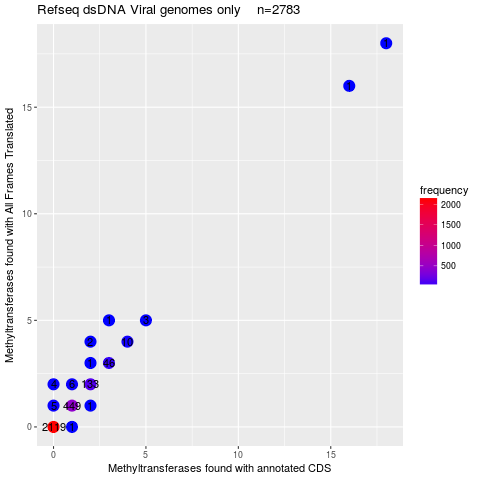

In [21]:
%%R -i forheatmap
#We will now compare counts from the two different annotations
library('ggplot2')
library('RColorBrewer')
library('ggrepel')
forheatmap$fqfactor <-as.factor(forheatmap$frequency)

n <-sum(forheatmap$frequency)
 
plt1<-ggplot (forheatmap, aes(y=allframes,x=annotatedCDS, label=fqfactor))+
  geom_point(aes(color=frequency),size=5)+
  geom_text(nudge_x = 0, nudge_y = 0)+
  scale_color_gradient(low="blue", high="red")+
  labs(y='Methyltransferases found with All Frames Translated', x='Methyltransferases found with annotated CDS',
      title = paste(c("Refseq dsDNA Viral genomes only    n=",n),collapse="")
      )


plotlist = list()
plotlist[[1]]=plt1



pdf("figures/control_allframesVSrefseqcds.pdf")
invisible(lapply(plotlist, print))
dev.off()

print(plt1)


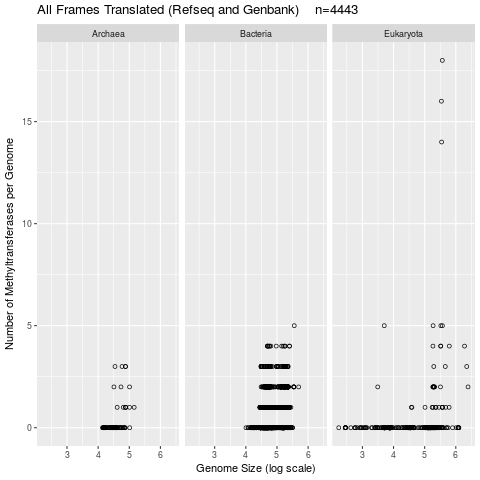

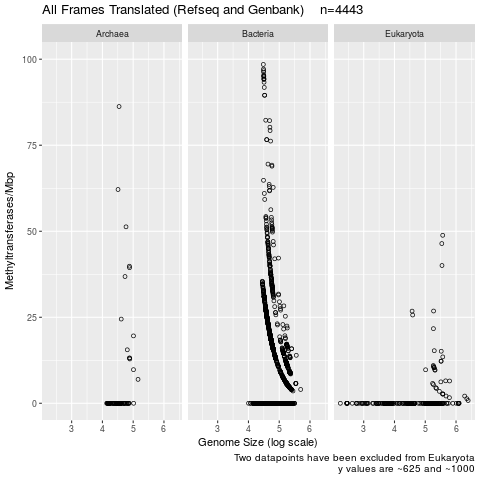

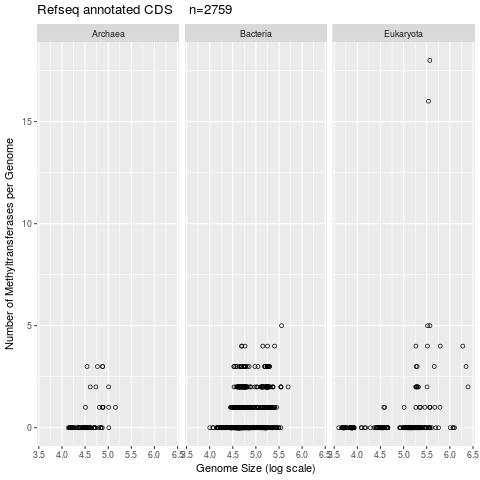

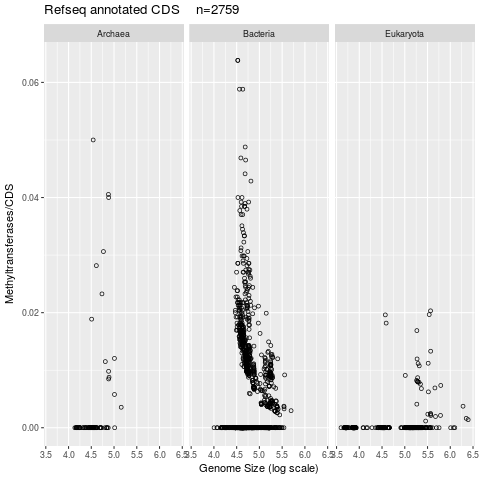

In [22]:
%%R
#we will filter for only dsDNA viruses, and also filter for host_lineage to be Archaea, Bacteria or Eukaryota
dsDNA<-read.csv('/home/spiridon/Documents/projects/Viral_MT/data/dsDNAviruses.csv',sep='\t')

dsDNA <- dsDNA[which(dsDNA$host_domain=='Archaea' | dsDNA$host_domain=='Bacteria' | dsDNA$host_domain=='Eukaryota'),]
allframes <- dsDNA[which(dsDNA$CDStype=='allframes'),]
refseq <- dsDNA[which(dsDNA$CDStype=='refseqCDS'),]

plt1 <- ggplot(allframes, aes(x=log10(bp),y=virus_MTtotal))+ 
  labs(y='Number of Methyltransferases per Genome', x='Genome Size (log scale)') + 
  geom_point(shape=1) + facet_wrap(~ host_domain, ncol=3)+ 
  ggtitle(paste(c('All Frames Translated (Refseq and Genbank)    n=',nrow(allframes)),collapse=""))

plt2 <- ggplot(allframes, aes(x=log10(bp),y=virus_MTtotal/bp*1000000))+ 
  labs(y='Methyltransferases/Mbp', x='Genome Size (log scale)',caption='Two datapoints have been excluded from Eukaryota\ny values are ~625 and ~1000') + 
  geom_point(shape=1) + facet_wrap(~ host_domain, ncol=3)+ 
  ggtitle(paste(c('All Frames Translated (Refseq and Genbank)    n=',nrow(allframes)),collapse=""))+
  ylim(0,100)


plt3 <- ggplot(refseq, aes(x=log10(bp),y=virus_MTtotal)) + 
  labs(y='Number of Methyltransferases per Genome', x='Genome Size (log scale)') + 
  geom_point(shape=1) + 
  facet_wrap(~ host_domain, ncol=3)+ 
  ggtitle(paste(c('Refseq annotated CDS    n=',nrow(refseq)),collapse=""))

plt4 <- ggplot(refseq, aes(x=log10(bp),y=virus_MTtotal/numCDS)) + 
  labs(y='Methyltransferases/CDS', x='Genome Size (log scale)') + 
  geom_point(shape=1) + 
  facet_wrap(~ host_domain, ncol=3)+ 
  ggtitle(paste(c('Refseq annotated CDS    n=',nrow(refseq)),collapse=""))

plotlist = list()
plotlist[[1]]=plt1
plotlist[[2]]=plt2
plotlist[[3]]=plt3
plotlist[[4]]=plt4
pdf("figures/dsviruses.pdf")
invisible(lapply(plotlist, print))
dev.off()

print(plt1)
print(plt2)
print(plt3)
print(plt4)

In [23]:
viraldat_over4MTases = viraldat.loc[viraldat['virus_MTtotal'] > 4]
viraldat_over4MTases['name'] = [catalog.get_name(assembly) for assembly in viraldat_over4MTases['assembly'] ]
viraldat_over4MTases.to_csv('data/viraldat_over4MTases.csv')
viraldat_over4MTases

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,assembly,CDStype,host_taxid,host_domain,evidence,is_inherited,bp,numcontigs,accession,numCDS,...,pEndo,pRM,T4,T2G,pT4,pT2G,virus_RM,virus_MTtotal,virus_lineage,name
53,GCF_000847045,allframes,114055;554065,Eukaryota,"UniProt;Literature, RefSeq",False,330611,1,NC_000852,29604,...,0,0,0,0,0,0,0,5,"dsDNA viruses, no RNA stage",Paramecium bursaria Chlorella virus 1
2355,GCF_000871245,allframes,554065,Eukaryota,Literature,False,344691,1,NC_009899,28092,...,0,0,0,1,0,0,1,16,"dsDNA viruses, no RNA stage",Paramecium bursaria Chlorella virus AR158
2591,GCF_000873685,allframes,114055;554065,Eukaryota,UniProt;Literature,False,368683,1,NC_009898,29609,...,0,0,0,1,0,0,1,18,"dsDNA viruses, no RNA stage",Paramecium bursaria Chlorella virus NY2A
4627,GCF_000898015,allframes,28141,Bacteria,RefSeq,False,358663,1,NC_019401,41265,...,0,0,0,0,0,0,0,5,"dsDNA viruses, no RNA stage",Cronobacter phage vB_CsaM_GAP32
5278,GCA_002628245,allframes,,,,,490380,1,MF403008,51298,...,0,0,0,0,0,0,0,6,unclassified bacterial viruses,Agrobacterium phage Atu_ph07
5363,GCF_000905435,allframes,242159,Eukaryota,"Literature, RefSeq",False,186468,1,NC_020852,16730,...,0,0,0,0,0,0,0,5,"dsDNA viruses, no RNA stage",Ostreococcus lucimarinus virus OlV5
7001,GCF_000922335,allframes,44056,Eukaryota,"Literature, RefSeq",False,370920,1,NC_024697,46557,...,0,0,0,0,0,0,0,5,"dsDNA viruses, no RNA stage",Aureococcus anophagefferens virus
12760,GCA_002833785,allframes,,Eukaryota,inferred_taxonomically,True,349604,2,AF062394;JX997183,28592,...,0,0,0,1,0,0,2,14,"dsDNA viruses, no RNA stage",Paramecium bursaria Chlorella virus NYs1
12762,GCA_002833805,allframes,,Eukaryota,inferred_taxonomically,True,5035,5,AY338214;CVU65736;CVU65738;CVU65737;CVU65739,495,...,0,0,0,0,0,0,0,5,"dsDNA viruses, no RNA stage",Paramecium bursaria Chlorella virus SC1A
14083,Partial_NCLDV_Genomes,allframes,,,,,668031,1,KY322437,57154,...,0,0,0,1,0,0,1,5,unclassified viruses,unclassified viruses


In [24]:
#Gathering information for Chlorovirus

cv_assemblies = catalog.get_subtree_assemblies(181083)
cv_assemblies.add('Partial_NCLDV_Genomes')# Tetraselmis virus 1 (viruses)
#removing version
cv_assemblies = [el.split('.')[0] for el in cv_assemblies]
cv=viraldat.loc[viraldat['assembly'].isin(cv_assemblies)]
cv['name'] = [catalog.get_name(assembly) for assembly in cv['assembly'] ]
cv.to_csv('data/chlorella_virus.csv')
cv[['name','assembly','CDStype','bp','numcontigs','numCDS','virus_RM','virus_MTtotal','virus_lineage']]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,name,assembly,CDStype,bp,numcontigs,numCDS,virus_RM,virus_MTtotal,virus_lineage
53,Paramecium bursaria Chlorella virus 1,GCF_000847045,allframes,330611,1,29604,0,5,"dsDNA viruses, no RNA stage"
2029,Paramecium bursaria Chlorella virus FR483,GCF_000867825,allframes,321240,1,23966,1,2,"dsDNA viruses, no RNA stage"
2207,Acanthocystis turfacea chlorella virus 1,GCF_000869685,allframes,288047,1,17983,0,1,"dsDNA viruses, no RNA stage"
2355,Paramecium bursaria Chlorella virus AR158,GCF_000871245,allframes,344691,1,28092,1,16,"dsDNA viruses, no RNA stage"
2591,Paramecium bursaria Chlorella virus NY2A,GCF_000873685,allframes,368683,1,29609,1,18,"dsDNA viruses, no RNA stage"
11089,Only Syngen Nebraska virus 5,GCF_001887825,allframes,327147,1,27110,0,4,"dsDNA viruses, no RNA stage"
12350,Paramecium bursaria Chlorella virus CVA-1,GCA_002827565,allframes,326592,1,24289,1,4,"dsDNA viruses, no RNA stage"
12352,Paramecium bursaria Chlorella virus AL2A,GCA_002827585,allframes,285,1,28,0,0,"dsDNA viruses, no RNA stage"
12354,Paramecium bursaria Chlorella virus CA4B,GCA_002827605,allframes,285,1,30,0,0,"dsDNA viruses, no RNA stage"
12356,Paramecium bursaria Chlorella virus IL3A,GCA_002827625,allframes,426,1,36,0,0,"dsDNA viruses, no RNA stage"
